Code Lab 1: Skin Cancer MNIST
=========================

## The Problem

From ISIC 2018: Skin Lesion Analysis Website [https://challenge2018.isic-archive.com]

> Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.

![skin-cancer-cover](imgs/skin-mnist-cover.png "Examples of Skin Lesions")

## Imports

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import pandas as pd
from IPython.display import display, HTML

Let's import Tensorflow now.  It is helpful after importing Tensorflow to check the version of the library installed since the API's are changing so quickly.  Several machines are now starting to use Tensorflow 2.0rc which has a very different interface from v1.* as well.  In preparation for TF 2.0, this tutorial will use the Eager Execution API, which is used by default in future version.

In [3]:
import tensorflow as tf
tf.enable_eager_execution()

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print('Tensorflow version: ',tf.__version__)
print('Is GPU available: %s' % str(tf.test.is_gpu_available()))
print('Is Eager Execution enabled?: %s' % str(tf.executing_eagerly()))

Tensorflow version:  1.13.1
Is GPU available: False
Is Eager Execution enabled?: True


## Dataset

### About HAM10000

In this exercise will will be using  HAM10000 ("Human Against Machine with 10000 training images") dataset which is a collection of "dermatoscopic images from different populations, acquired and stored by different modalities."[Kaggle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000) This dataset has ~10K dermatoscopic images that have been reformatted to be similar smaller like the famous Handwritten Digit or MNIST dataset (64 x 64 images centered on the subject).  This allows us to focus on setting up our environment and making sure we can get a model working on a more interesting, healthcare-related problem.

### Load the dataset

We will load both the included meta file as well as the image data (provided conveniently as a CSV file with one row per image.

In [4]:
IS_ONEPANEL = False
NEED_DOWNLOAD = False
if IS_ONEPANEL:
    DATA_DIR='/onepanel/input'
else:
    import os
    import load_data
#     DATA_DIR = '/storage/codelab1'
    DATA_DIR = 'data'
    if NEED_DOWNLOAD:
        if not os.path.exists(DATA_DIR):
            os.mkdir(DATA_DIR)
        FILELIST = ['HAM10000_metadata.csv','train.npz','val.npz']
        load_data.download_files(FILELIST,DATA_DIR)

In [5]:
meta_df = pd.read_csv(os.path.join(DATA_DIR,'HAM10000_metadata.csv'))
train_data = np.load(os.path.join(DATA_DIR,'train.npz'))
test_data = np.load(os.path.join(DATA_DIR,'val.npz'))

### Inspect the meta data

#### Lesions with multiple images

For each image we have a `lesion_id` as well as a an `image_id`.  We should note that there are in fact multiple images for the same lesion which we need to be mindful of as we construct our training and testing splits.  While this has been accounted for in the pre-made splits, it is a potential leakage between the training and validation splits if the same patients were in both populations.

In [9]:
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dupe
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,True
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,True
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,True
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,True
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,True


Below, we count the occurrences of a lesion_id, accumulate the lesions ids with more than 1 image and then add a flag to our original meta_df to indicate whether the lesion has more than one image in the dataset.

In [10]:
def pretty_count_print(series):
    display(pd.DataFrame(series.value_counts()))

In [11]:
lesion_image_counts = pd.DataFrame( meta_df.groupby('lesion_id')['image_id'].count())
dupe_lesion_ids = list(lesion_image_counts[lesion_image_counts['image_id'] > 1].index.values)
meta_df['dupe'] = meta_df.apply(lambda row: row['lesion_id'] in dupe_lesion_ids, axis=1)
pretty_count_print(meta_df['dupe'])

,dupe
False,5514
True,4501


### Classes

The dataset contains 7 classes of lesions, a mixture of both benign and cancerous types.  The dataset is overweight to benign melanocytic nevi, a harmless mole.  However, there are over 2,000 examples of cancerous lesions to detect in this dataset.


| Id |Abbr | Name |
|---|---|---|
| 4 | nv | Melanocytic nevi |
| 6 | mel | Melanoma |
| 2 | bkl | Benign keratosis-like lesion |
| 1 | bcc | Basal cell carcinoma |
| 0 | akiec |  Actinic keratoses |
| 5 | vasc | Vascular lesions (angiomas, etc.) |
| 3 | df | Dermatofibroma |

In [12]:
class_list = ['akiec','bcc','bkl','df','mel','nv','vasc']
pretty_count_print(meta_df['dx'])

,dx
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


Let's gather examples of each class to inspect visually.

In [13]:
example_list = {}
class_names = ['akiec', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']
for cls in range(7):
    example_list[class_names[cls]] = np.nonzero(train_data['labels'] == cls)[0][0]
display(example_list)

{'akiec': 0,
 'df': 301,
 'bkl': 410,
 'vasc': 1434,
 'nv': 1565,
 'bcc': 7519,
 'mel': 8003}

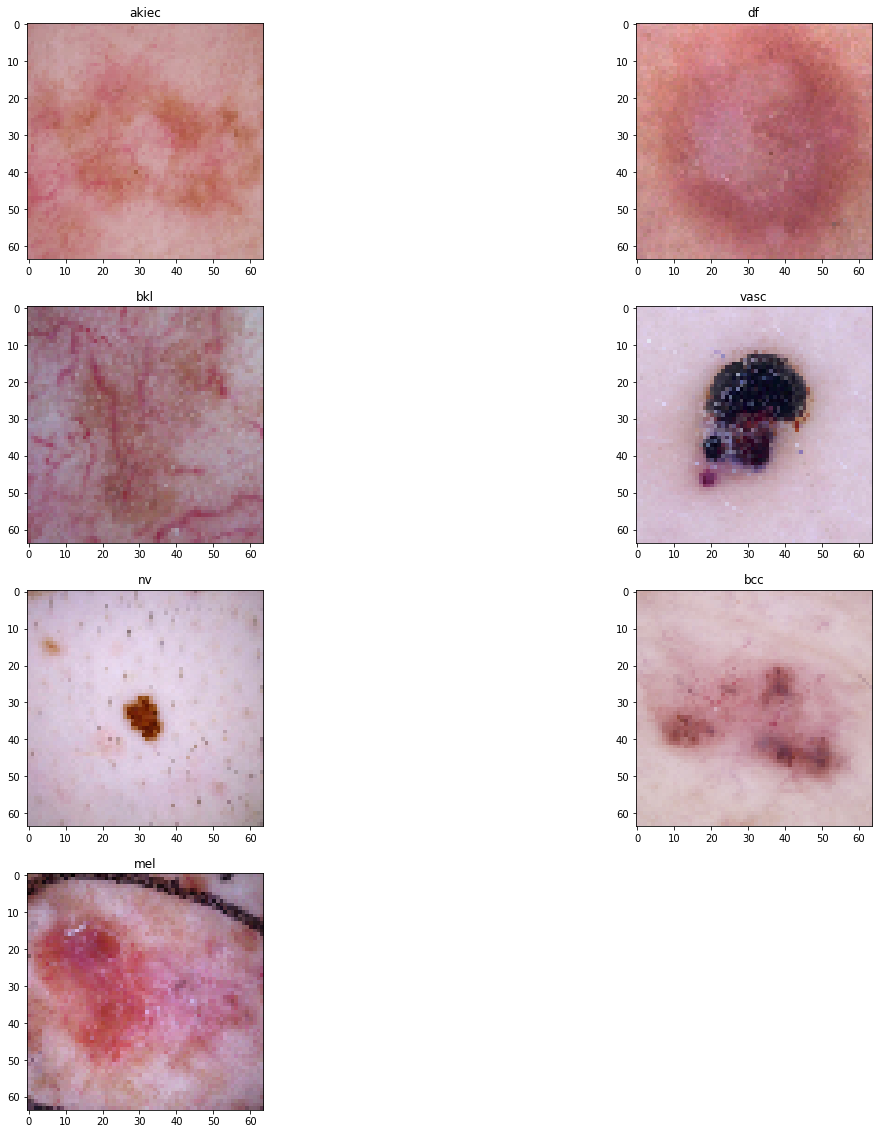

In [14]:
fig, ax = plt.subplots(4,2, figsize=(20,20))
fig.delaxes(ax[3,1]) # Delete the extra plot
for i, (key, value) in enumerate(example_list.items()):
    ax[i//2,i%2].title.set_text(key)
    ax[i//2,i%2].imshow(train_data['images'][value])

### Prepare the data

For this step we will split the dataset into two parts: 1) a training set on which the parameters of the neural network model will be learning, 2) a held-out evaluation set that we will use to score the performance of our model.  Also we will preprocess our data and build functions for feeding our data to our model according to the Eager Execution API.

#### Train/Test Split

We have already created a 90/10 split for the test set.

#### Preprocessing

Uniquely with toy datasets like this one, there is not much in the way of preprocessing to accomplish.  We will simply scale the 8-bit color values normalizing the per-channel mean and variance.  It is common practice to only calculate these statistics only on the training population, but use the same normalization parameters for both populations during preprocessing.

In [34]:
channel_mean = np.mean(train_data['images'],axis=(0,1,2))

channel_std = np.std(train_data['images'],axis=(0,1,2))

print("Channel mean: %s" % str(channel_mean))
print("Channel std: %s" % str(channel_std))

train_x = (train_data['images'] - channel_mean) / channel_std
test_x = (test_data['images'] - channel_mean) / channel_std
print("Processed color range: %0.3f to %0.3f" % (np.min(train_x),np.max(train_x)))

Channel mean: [193.70557095 137.91040133 144.01527852]
Channel std: [35.38412952 40.65661319 45.484523  ]
Processed color range: -5.474 to 2.880


Given the imbalance of the dataset and the low resolution that we are using for demonstration purposes, we will confine ourselves to the binary classification problem of whether a lesion is a Nevus or not a Nevus.  Unfortunately there is a higher proporation of nevi in the test set.

In [37]:
train_y = np.where(train_data['labels']==4,1,0).reshape(-1,1).astype(np.float32)
test_y = np.where(test_data['labels']==4,1,0).reshape(-1,1).astype(np.float32)

In [38]:
print("Proportion of nevi in train: %0.2f%% vs test: %0.2f%%" 
      % (np.mean(train_y)*100., np.mean(test_y) *100))

Proportion of nevi in train: 65.59% vs test: 80.06%


One last check before proceeding, let's check the data types and sizes of our input data.

In [39]:
print(train_x.shape, train_x.dtype, train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype, test_y.shape, test_y.dtype)

(9077, 64, 64, 3) float64 (9077, 1) float32
(938, 64, 64, 3) float64 (938, 1) float32


#### Data Loading functions

These functions will load all of the data into the device memory in a format that the Eager Execution API works well when the data provided is via `tf.data.Dataset` which helps create an interable collection of tensors.

In [115]:
BATCH_SIZE=64

In [144]:
def augment(images, labels):
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    return images, labels

In [145]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset = train_dataset.map(augment).shuffle(2000).batch(BATCH_SIZE)

In [146]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_x,test_y))
test_dataset = test_dataset.batch(BATCH_SIZE)

## Model

Now we will construct the model using the modular Keras API, which will become the preferred method for building models in Tensorflow 2.0.  Specifically we will create a new model class that subclasses `tf.keras.Model` to incorporate our model design.  This helps with organizing the state of our graph as well as helps make models easier to replicate.

In [147]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.activations import sigmoid, softmax

### Design Parameters

There are a number of parameters required when building the model.  Below, we collect the parameters required in the model in the `model_design_params` nested dictionary.  The structure of the dictionary largely follows the design of the `VGG` like model that we will use to detect whether a lesion is a nevus or not.

In [148]:
model_design_params = {
    'blocks' : {
         'conv2d': {
             'kernel_size': 3,
             'strides': 1,
             'padding':'same',
             'activation':'relu',
          },
         'pooling': {
             'pool_size': 2,
             'strides': 2,
          },
         'dropout': 0.25,
     },
     'head' : {
         'affine' : {
             'units': 512,
             'activation': 'relu',
         },
         'dropout': 0.3,
          'logits' : {
             'units': 1,
             'activation': None,
         },   
     }
}

### Model Definition

In [149]:
class VGGStyleBlock(Model):
    def __init__(self, filters, params):
        super(VGGStyleBlock, self).__init__()
        self.conv1 =  Conv2D(filters, **params['conv2d']) # +2 RF
        self.conv2 =  Conv2D(filters, **params['conv2d']) # +2 RF
        self.maxpool = MaxPooling2D(**params['pooling']) # 2x+1 RF
        self.dropout = Dropout(params['dropout'])
        self.sequential =   Sequential([self.conv1,
                                        self.conv2,
                                        self.maxpool,
                                        self.dropout]) # put it all together
    def call(self, x):
        return self.sequential(x)

In [150]:
class NevusCNNClassifier(Model):
  '''
  This is our class that we will use to define our model.
  '''
  def __init__(self,params):
    super(NevusCNNClassifier, self).__init__()
    
    # Block 1: 64x64x3 -> 32x32x32
    self.block1 = VGGStyleBlock(32,model_design_params['blocks'])
    
    # Block 2: 32x32x32 -> 16x16x64
    self.block2 = VGGStyleBlock(64,model_design_params['blocks'])
    
    # Block 3: 16x16x64 -> 8x8x128
    self.block3 = VGGStyleBlock(128,model_design_params['blocks'])

    # Features 8x8x128 -> 128 vector representations
    self.gap =      GlobalAveragePooling2D()
    self.features = Sequential([self.block1,
                                self.block2,
                                self.block3,
                                self.gap])
    
    # Head
    self.affine =   Dense(**params['head']['affine'])
    self.head_dropout = Dropout(params['head']['dropout'])
    self.logits =   Dense(**params['head']['logits'])
    self.head =     Sequential([self.affine,
                                self.head_dropout, 
                                self.logits])
    
  def call(self, x):
    x = self.features(x)
    logits = self.head(x)
    probability  = sigmoid(logits)
    return logits, probability

In [151]:
# Create an instance of the model
model = NevusCNNClassifier(model_design_params)

Now that we've constructed the models.  Let's inspect the models now.  Keras comes with two handy built-in features for inspecting models.  Specfically, `model.summary()` and `keras.utils.plot_model`.

In [152]:
tmp = NevusCNNClassifier(model_design_params)
tmp.build((1,64,64,3))
tmp.features.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg_style_block_78 (VGGStyle multiple                  20288     
_________________________________________________________________
vgg_style_block_79 (VGGStyle multiple                  110848    
_________________________________________________________________
vgg_style_block_80 (VGGStyle multiple                  442880    
_________________________________________________________________
global_average_pooling2d_30  multiple                  0         
Total params: 287,008
Trainable params: 287,008
Non-trainable params: 0
_________________________________________________________________


In [153]:
tmp.head.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             multiple                  66048     
_________________________________________________________________
dropout_118 (Dropout)        multiple                  0         
_________________________________________________________________
dense_59 (Dense)             multiple                  513       
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________


## Train

TALK ABOUT TENSORBOARD AND ALL OF THE THINGS ESTIMATOR GIVES YOU FOR FREE

### Training Setup

In [154]:
LEARNING_RATE = 1.e-3
CLIPVALUE = 1.
EPOCHS = 10

#### Loss Function

In [155]:
# optimizer = tf.train.MomentumOptimizerOptimizer(learning_rate=LEARNING_RATE,momentum=0.9)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
loss_function = tf.losses.sigmoid_cross_entropy

#### Performance Metrics

In [156]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

#### Training Step

In [157]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits, probability = model(images)
    loss = loss_function(labels, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, probability)

In [158]:
for image, label in train_dataset.take(10):
    train_step(image,label)
    print("{} {}".format(train_loss.result(),
                    train_accuracy.result()*100))

0.6868259906768799 82.8125
2.5739669799804688 80.46875
1.9355674982070923 76.5625
1.6239393949508667 73.046875
1.4358197450637817 72.8125
1.3100863695144653 72.13542175292969
1.2200987339019775 71.20536041259766
1.1530778408050537 69.7265625
1.099979281425476 69.09722137451172
1.0577448606491089 68.28125


#### Evaluation Step

In [159]:
def test_step(images, labels):
  logits, probability = model(images)
  t_loss = loss_function(labels, logits)

  test_loss(t_loss)
  test_accuracy(labels, probability)

In [160]:
for image, label in train_dataset.take(1):
    test_step(image,label)
    print("{} {}".format(test_loss.result(),
                    test_accuracy.result()*100))

0.6274549961090088 82.8125


#### Training Loop

In [ ]:
for epoch in range(EPOCHS):
  step = 0
  for images, labels in train_dataset:
    train_step(images, labels)
    if step % 30 == 29:
        print("Step {}: {} {}".format(step, train_loss.result(),
                            train_accuracy.result()*100))
    step += 1

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

0.7261689901351929 65.625
0.5854226350784302 72.0535659790039


## Evaluation

### Score the Model

In [ ]:
eval_results = ham_classifier.evaluate(input_fn=test_input_fn)
print(eval_results)

### Inspect Predictions

### Inspect feature vector

In [ ]:
'a'